In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt

In [2]:
!pip install seaborn==0.12.0

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import seaborn as sns
sns.__version__

'0.12.0'

In [4]:
pd.__version__

'1.3.4'

In [5]:
# perturbation_output_filepath = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240710/sars-cov-2/uniprot/cov-S-multi-transfer_learning_mlm_cls_hybrid_attn_fnn_2l_lr1e-4/aligned_msl256_s64/processed/tl_tf_multi_coronaviridae_s_uniprot_sars_cov_2_aligned.csv_WIV04.csv")
perturbation_output_filepath = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240710/sars-cov-2/uniprot/cov-S-multi-transfer_learning_mlm_cls_hybrid_attn_fnn_2l_lr1e-4/aligned_msl128_s64/processed/tl_tf_multi_coronaviridae_s_uniprot_sars_cov_2_aligned.csv_WIV04.csv")

human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"
classes=["Pig", "Human", "Cat", "Dromedary camel", "Cattle", "Chicken", "Gray wolf", "Yak"]

In [6]:
def get_perturbation_output(perturbation_output_filepath):
    df = pd.read_csv(perturbation_output_filepath)
    orig_seq_df = df[df["orig_token"] == df["new_token"]]
    orig_pred_val = orig_seq_df[human_label].values[0]
    orig_pred_class = orig_seq_df[classes].idxmax(axis=1).values[0]

    df[pred_diff_col] = df[human_label] - orig_pred_val
    df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
    df["orig_y_pred"] = orig_pred_class
    df["new_y_pred"] = df[classes].idxmax(axis=1)
    return df

In [7]:
import textwrap
def wrap_xticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_xticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_xticklabels(wrapped_labels, rotation=0)
    
def wrap_yticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_yticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_yticklabels(wrapped_labels, rotation=0)

In [8]:
import math

def get_uniformly_divided_position_bins(positions, n_bins):
    bin_width = math.floor(len(positions)/n_bins)
    bins = []
    start = 0
    for i in range(n_bins):
        end = start + bin_width
        bins.append(positions[start:end])
        start = end
    return bins

In [10]:
perturbed_output_df = get_perturbation_output(perturbation_output_filepath)
print(f"perturbed_output_df shape = {perturbed_output_df.shape}")

perturbed_output_df shape = (31826, 17)



#### WIV04 reference sequence

In [11]:
wiv04_aligned_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "input/data/coronaviridae/20240313/uniprot/alignment/coronaviridae_s_uniprot_uniprot_metadata_embl_hosts_pruned_metadata_corrected_species_virus_host_vertebrates_w_seq_t0.01_c8_aligned.csv")
wiv04_df = pd.read_csv(wiv04_aligned_file_path)
wiv04_df = wiv04_df[wiv04_df["uniprot_id"] == "WIV04"]
wiv04_df.head()

,uniprot_id,aligned_seq,seq,virus_name,virus_host_name,human_binary_label
0,WIV04,-----MFVFLVLLPLVS---------------------------SQ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,WIV04(MN996528.1) Wuhan variant index virus,homo sapiens,homo sapiens


In [12]:
wiv04_aligned_seq = wiv04_df["aligned_seq"].values[0]
print(len(wiv04_aligned_seq))
wiv04_aligned_seq

2121


'-----MFVFLVLLPLVS---------------------------SQCVNLTTRTQLPP--AYTN--SFTR-----------------------------GVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNI-----IRGWIFGTTLDS----------KTQSLLIVNNAT----------N--------------VVIKVCEFQFCN-----------------------------------------------------------------DPFLGVY--------YHKNNK--------SWMESEF-RVYSS-----ANNCT-----FEYVSQP--FLMDLEGKQGNFK-------------NLREFVFK-NIDGYFKIYSKHTPINL---VRD-------------------------LPQGFS-------------------ALEPLV-----------------------------------DLPIGI--------NIT---------------------------------RFQTLLALHRSYLT-----PGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQ----PTESI---VRF-----PNITNLC----PFGEVF-------------------NATR-------------FASVYAWNRK-----------RISNCVADYSVLYNS-ASFSTFKC-----------YGVSPTKL----------------------NDLCFTNVYADSF----------VIRGD-------------------EVR-QIA----------PGQTGKI------ADYNYKLPDDFT--------G----CV----------IA-------WNSNNLDSKVGGNYNYLY---RLFRKSNL-----KPFERDISTEIYQAGST-----

In [13]:
wiv04_position_mapping = {}
pos = 0
for i, token in enumerate(wiv04_aligned_seq):
    if token == "-":
        continue
    else:
        pos += 1
        wiv04_position_mapping[i] = int(pos)
        
perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_pos"].apply(lambda x: int(wiv04_position_mapping[x]) if x in wiv04_position_mapping else None)        
perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_seq_pos"].astype("Int64")

In [14]:
perturbed_output_df

,Cat,Cattle,Chicken,Dromedary camel,Gray wolf,Human,Pig,Yak,uniprot_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturb_seq_pos
0,0.169229,0.000320,0.003142,0.000448,0.000899,0.821915,0.004038,0.000008,WIV04,Human,A,1786,Z,-2.030000e-06,2.030000e-06,Human,Human,1015
1,0.169229,0.000320,0.003142,0.000448,0.000899,0.821916,0.004038,0.000008,WIV04,Human,A,601,W,-1.200000e-06,1.200000e-06,Human,Human,262
2,0.169228,0.000320,0.003142,0.000448,0.000899,0.821916,0.004038,0.000008,WIV04,Human,P,1377,M,-9.000000e-07,9.000000e-07,Human,Human,681
3,0.169287,0.000321,0.003149,0.000449,0.000901,0.821840,0.004046,0.000008,WIV04,Human,S,1774,W,-7.736000e-05,7.736000e-05,Human,Human,1003
4,0.169231,0.000320,0.003142,0.000448,0.000899,0.821913,0.004039,0.000008,WIV04,Human,S,1774,V,-4.160000e-06,4.160000e-06,Human,Human,1003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31821,0.169228,0.000320,0.003142,0.000448,0.000899,0.821916,0.004038,0.000008,WIV04,Human,F,614,A,-6.600000e-07,6.600000e-07,Human,Human,275
31822,0.169229,0.000320,0.003142,0.000448,0.000899,0.821915,0.004038,0.000008,WIV04,Human,L,1709,E,-1.910000e-06,1.910000e-06,Human,Human,938
31823,0.169228,0.000320,0.003142,0.000448,0.000899,0.821917,0.004038,0.000008,WIV04,Human,V,2013,U,-5.600000e-07,5.600000e-07,Human,Human,1189
31824,0.169228,0.000320,0.003142,0.000448,0.000899,0.821917,0.004038,0.000008,WIV04,Human,F,412,K,0.000000e+00,0.000000e+00,Human,Human,201


In [15]:
perturbed_output_df = perturbed_output_df[~perturbed_output_df["perturb_seq_pos"].isna()]

In [56]:
perturbed_output_df[perturbed_output_df["perturb_seq_pos"]==493]

,Cat,Cattle,Chicken,Dromedary camel,Gray wolf,Human,Pig,Yak,uniprot_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturb_seq_pos,perturbation_id
754,0.169228,0.00032,0.003142,0.000448,0.000899,0.821917,0.004038,0.000008,WIV04,Human,Q,1057,R,-1.600000e-07,1.600000e-07,Human,Human,493,Q493R
4288,0.169228,0.00032,0.003142,0.000448,0.000899,0.821917,0.004038,0.000008,WIV04,Human,Q,1057,E,-6.000000e-08,6.000000e-08,Human,Human,493,Q493E
4504,0.169228,0.00032,0.003142,0.000448,0.000899,0.821917,0.004038,0.000008,WIV04,Human,Q,1057,T,-1.600000e-07,1.600000e-07,Human,Human,493,Q493T
4850,0.169228,0.00032,0.003142,0.000448,0.000899,0.821917,0.004038,0.000008,WIV04,Human,Q,1057,G,-1.600000e-07,1.600000e-07,Human,Human,493,Q493G
6903,0.169228,0.00032,0.003142,0.000448,0.000899,0.821917,0.004038,0.000008,WIV04,Human,Q,1057,F,-1.600000e-07,1.600000e-07,Human,Human,493,Q493F
8310,0.169228,0.00032,0.003142,0.000448,0.000899,0.821917,0.004038,0.000008,WIV04,Human,Q,1057,P,-3.000000e-07,3.000000e-07,Human,Human,493,Q493P
9202,0.169228,0.00032,0.003142,0.000448,0.000899,0.821917,0.004038,0.000008,WIV04,Human,Q,1057,I,-6.000000e-08,6.000000e-08,Human,Human,493,Q493I
9713,0.169228,0.00032,0.003142,0.000448,0.000899,0.821917,0.004038,0.000008,WIV04,Human,Q,1057,K,-1.600000e-07,1.600000e-07,Human,Human,493,Q493K
10132,0.169228,0.00032,0.003142,0.000448,0.000899,0.821917,0.004038,0.000008,WIV04,Human,Q,1057,N,-1.600000e-07,1.600000e-07,Human,Human,493,Q493N
10614,0.169231,0.00032,0.003142,0.000448,0.000899,0.821913,0.004038,0.000008,WIV04,Human,Q,1057,M,-3.760000e-06,3.760000e-06,Human,Human,493,Q493M


# Overview

### Distribution of Human class difference

In [17]:
def print_histogram(distribution, n_bins=20):
    n = distribution.shape[0]
    print(f"n={n}")
    freq, bins = np.histogram(distribution, bins=n_bins)
    hist_map = []
    for i in range(n_bins):
        hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})

    hist_df = pd.DataFrame(hist_map)
    print(hist_df.head(20))

In [18]:
selected_df = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
print(f"Number of sequences with abs_{pred_diff_col} >= 0.1: {selected_df.shape[0]} ({selected_df.shape[0]/perturbed_output_df.shape[0]*100})")

print("Distribution of full perturbation output")
print_histogram(perturbed_output_df[pred_diff_col], n_bins=20)
print("\n>>>>>>>>>>>>><<<<<<<<<<<<<<<<\n")
print(f"Distribution of perturbation output with |{pred_diff_col}| >= 0.1")
print_histogram(selected_df[pred_diff_col], n_bins=20)

Number of sequences with abs_Human_pred_diff >= 0.1: 27 (0.0848362973669327)
Distribution of full perturbation output
n=31826
       start       end  count  percentage
0  -0.318479 -0.300809      1    0.003142
1  -0.300809 -0.283140      0    0.000000
2  -0.283140 -0.265470      0    0.000000
3  -0.265470 -0.247801      0    0.000000
4  -0.247801 -0.230132      0    0.000000
5  -0.230132 -0.212462      0    0.000000
6  -0.212462 -0.194793      0    0.000000
7  -0.194793 -0.177123      0    0.000000
8  -0.177123 -0.159454      1    0.003142
9  -0.159454 -0.141785      0    0.000000
10 -0.141785 -0.124115      0    0.000000
11 -0.124115 -0.106446      0    0.000000
12 -0.106446 -0.088776     25    0.078552
13 -0.088776 -0.071107      5    0.015710
14 -0.071107 -0.053438      6    0.018853
15 -0.053438 -0.035768     17    0.053415
16 -0.035768 -0.018099     37    0.116257
17 -0.018099 -0.000429    624    1.960661
18 -0.000429  0.017240  31086   97.674857
19  0.017240  0.034909     24    0

<Figure size 432x288 with 0 Axes>

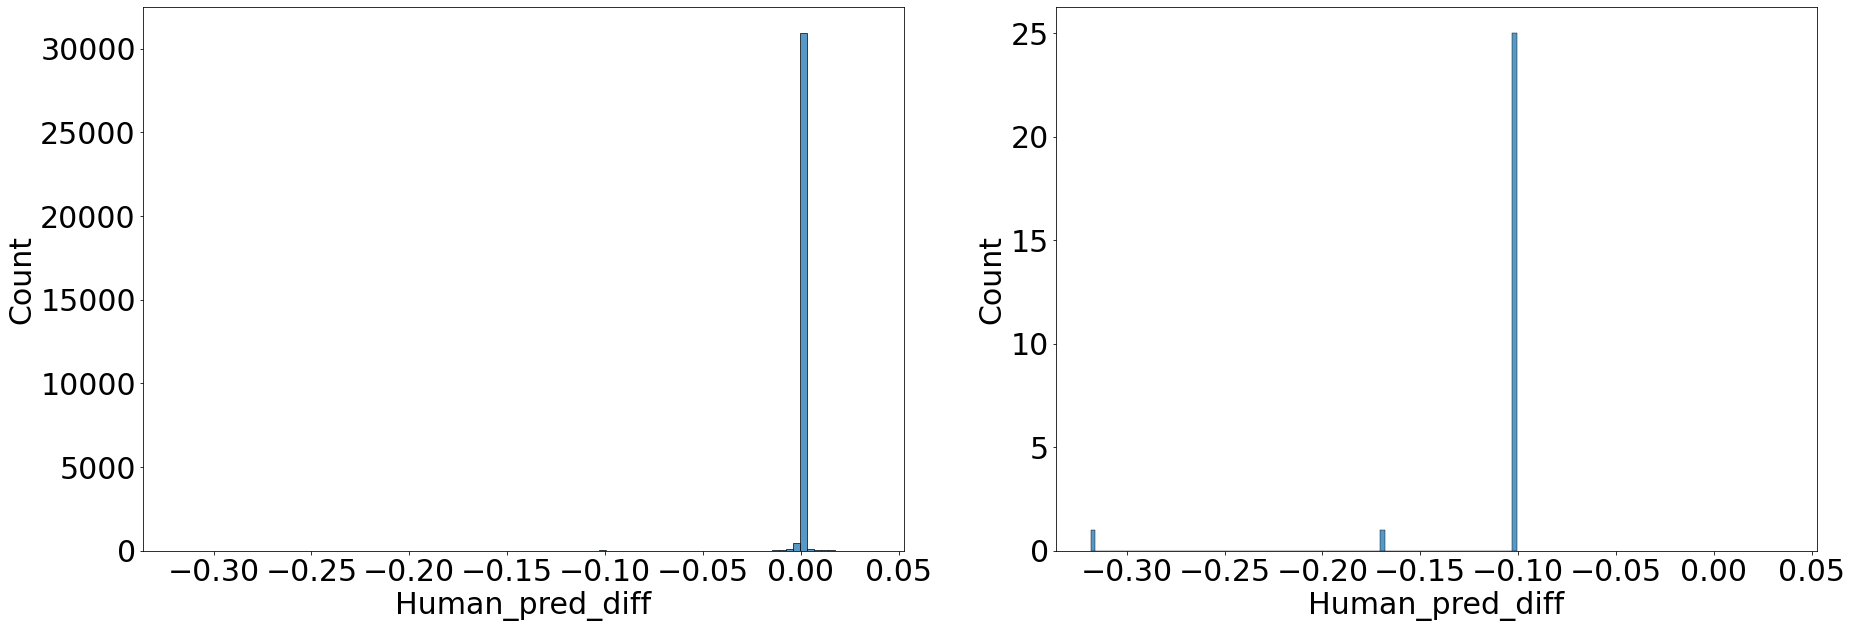

In [19]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 2, figsize=(30, 10), sharex=True, sharey=False)

sns.histplot(perturbed_output_df["Human_pred_diff"], bins=100, ax=axs[0])
sns.histplot(selected_df["Human_pred_diff"], bins=100, ax=axs[1])
plt.show()



### Distribution of Human pred diff in each position

<Figure size 432x288 with 0 Axes>

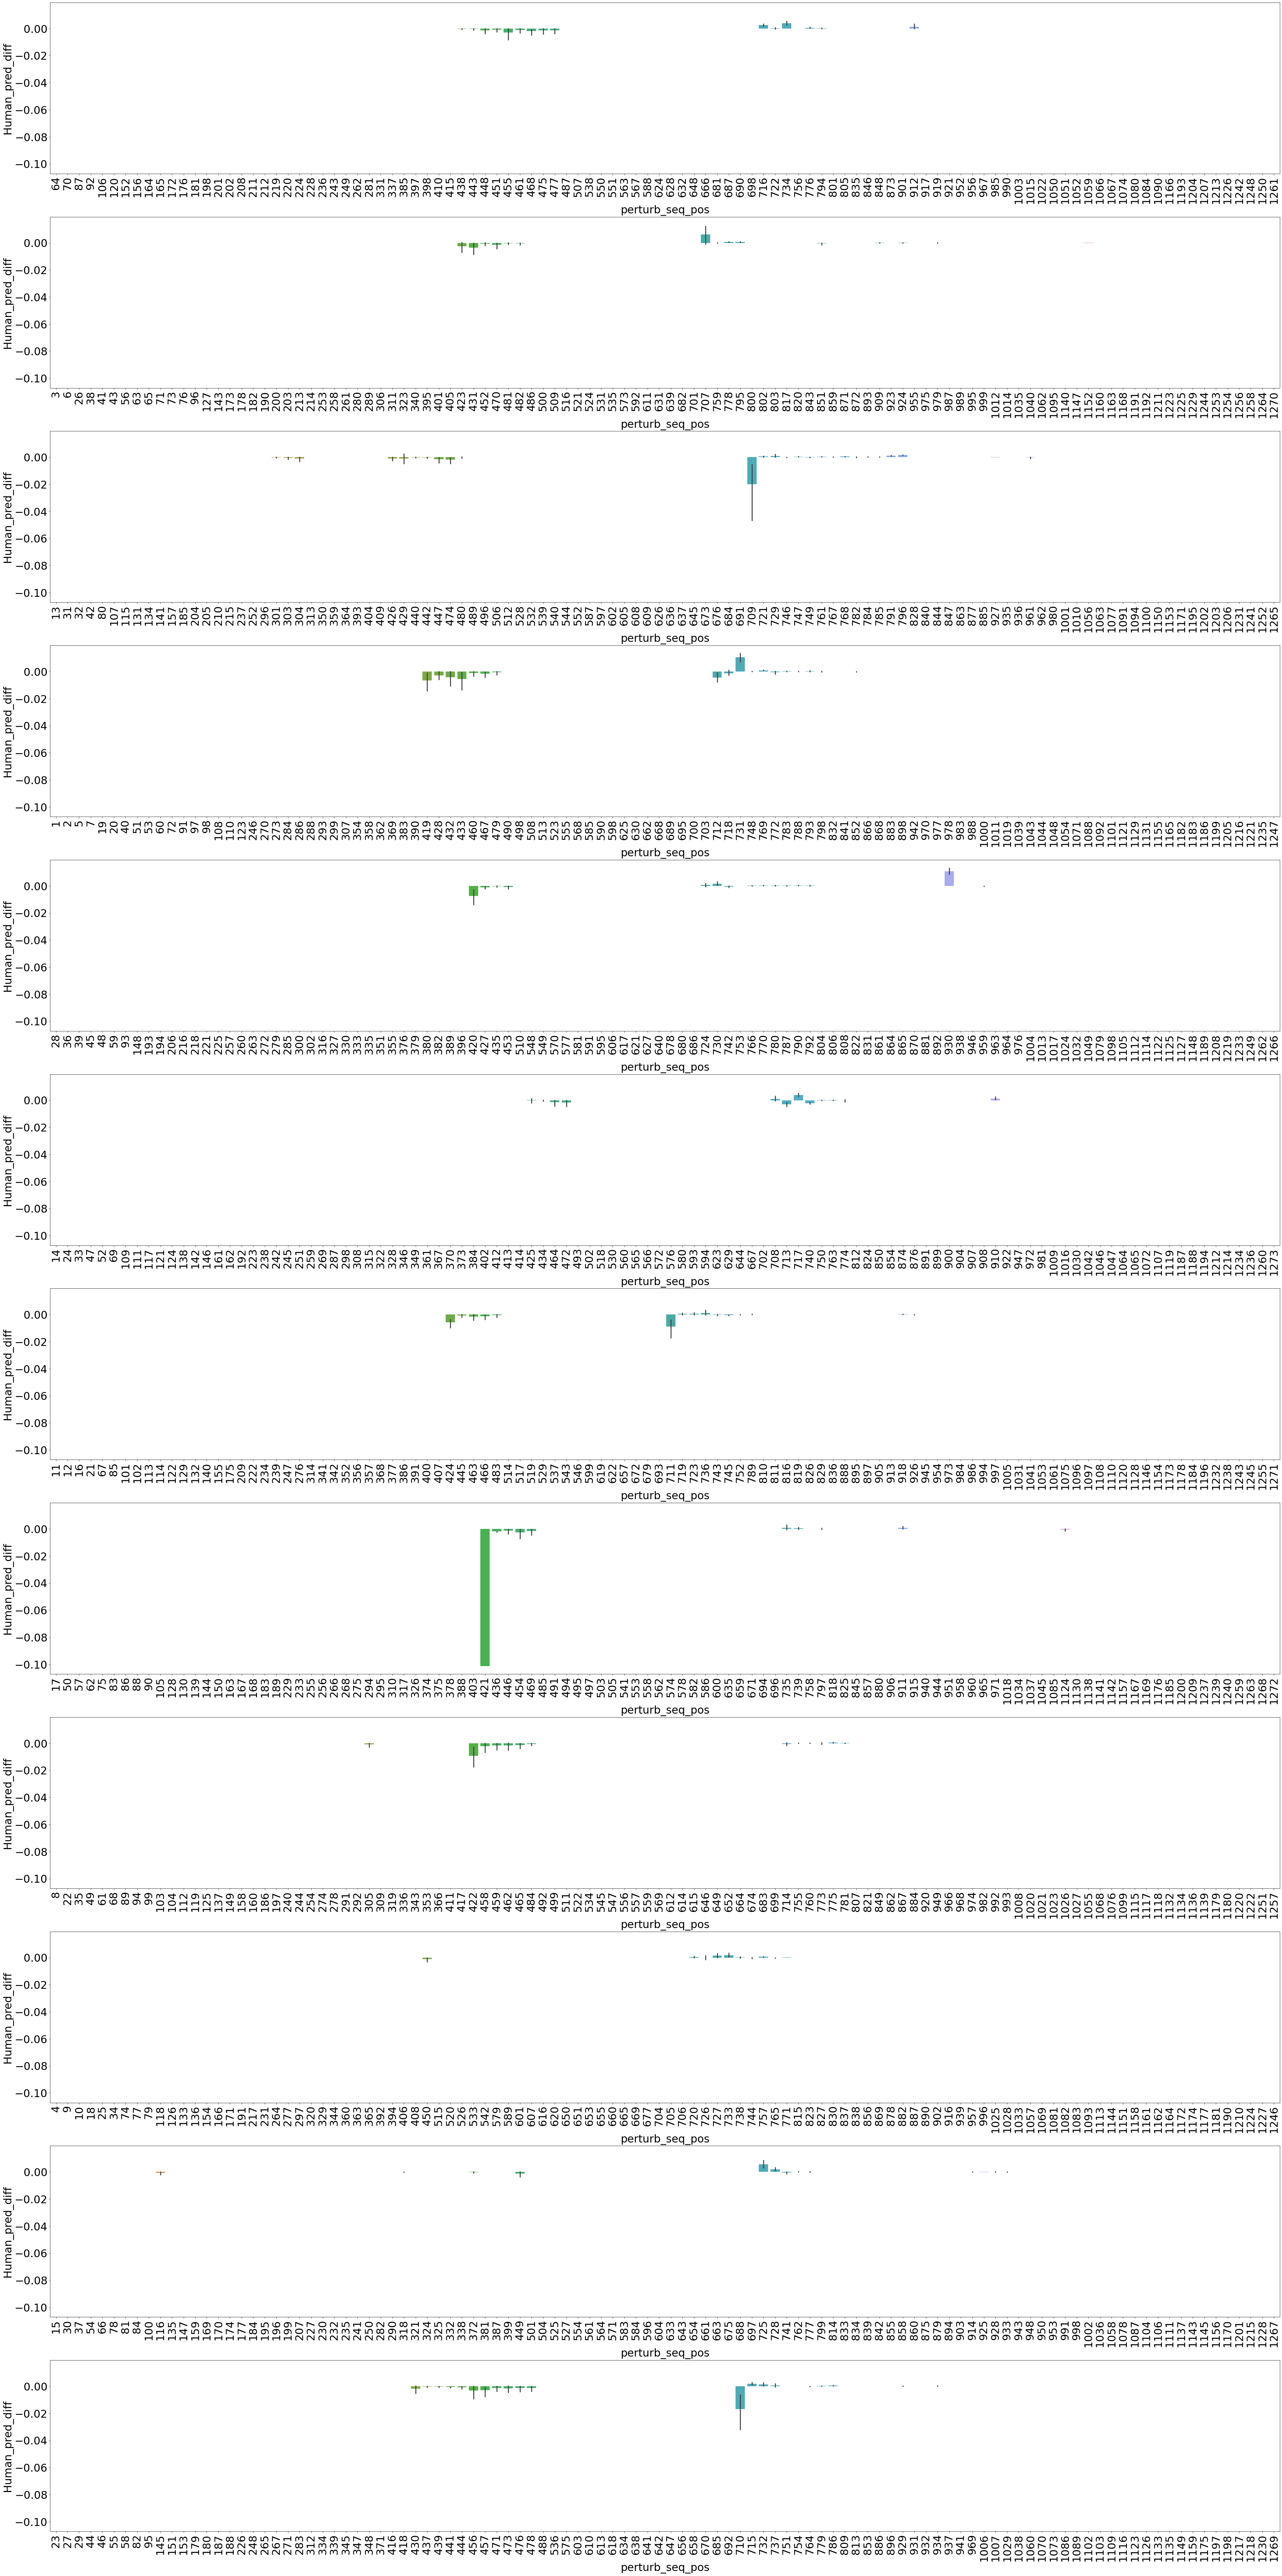

In [20]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
n = 12
fig, axs = plt.subplots(n, 1, figsize=(50, 100), sharex=False, sharey=True)

bins = get_uniformly_divided_position_bins(list(perturbed_output_df["perturb_seq_pos"].unique()), n)

for i in range(n):
    sns.barplot(perturbed_output_df[perturbed_output_df["perturb_seq_pos"].isin(bins[i])], x="perturb_seq_pos", y=pred_diff_col, ax=axs[i])
    axs[i].tick_params(axis='x', rotation=90)
    
plt.tight_layout(pad=.1)
plt.show()

### Cut-off: mean=0 and variance=0

In [21]:
mean_std_df = perturbed_output_df.groupby("perturb_seq_pos").agg(mean=(pred_diff_col, "mean"), std=(pred_diff_col, "std")).reset_index()
cut_off_pos = list(mean_std_df[(mean_std_df["mean"] == 0) & (mean_std_df["std"] == 0)]["perturb_seq_pos"].values)
cut_off_df_1 = perturbed_output_df[~perturbed_output_df["perturb_seq_pos"].isin(cut_off_pos)]
cut_off_pos_1 = set(cut_off_df_1["perturb_seq_pos"].unique())
len(cut_off_pos_1)


1264

<Figure size 432x288 with 0 Axes>

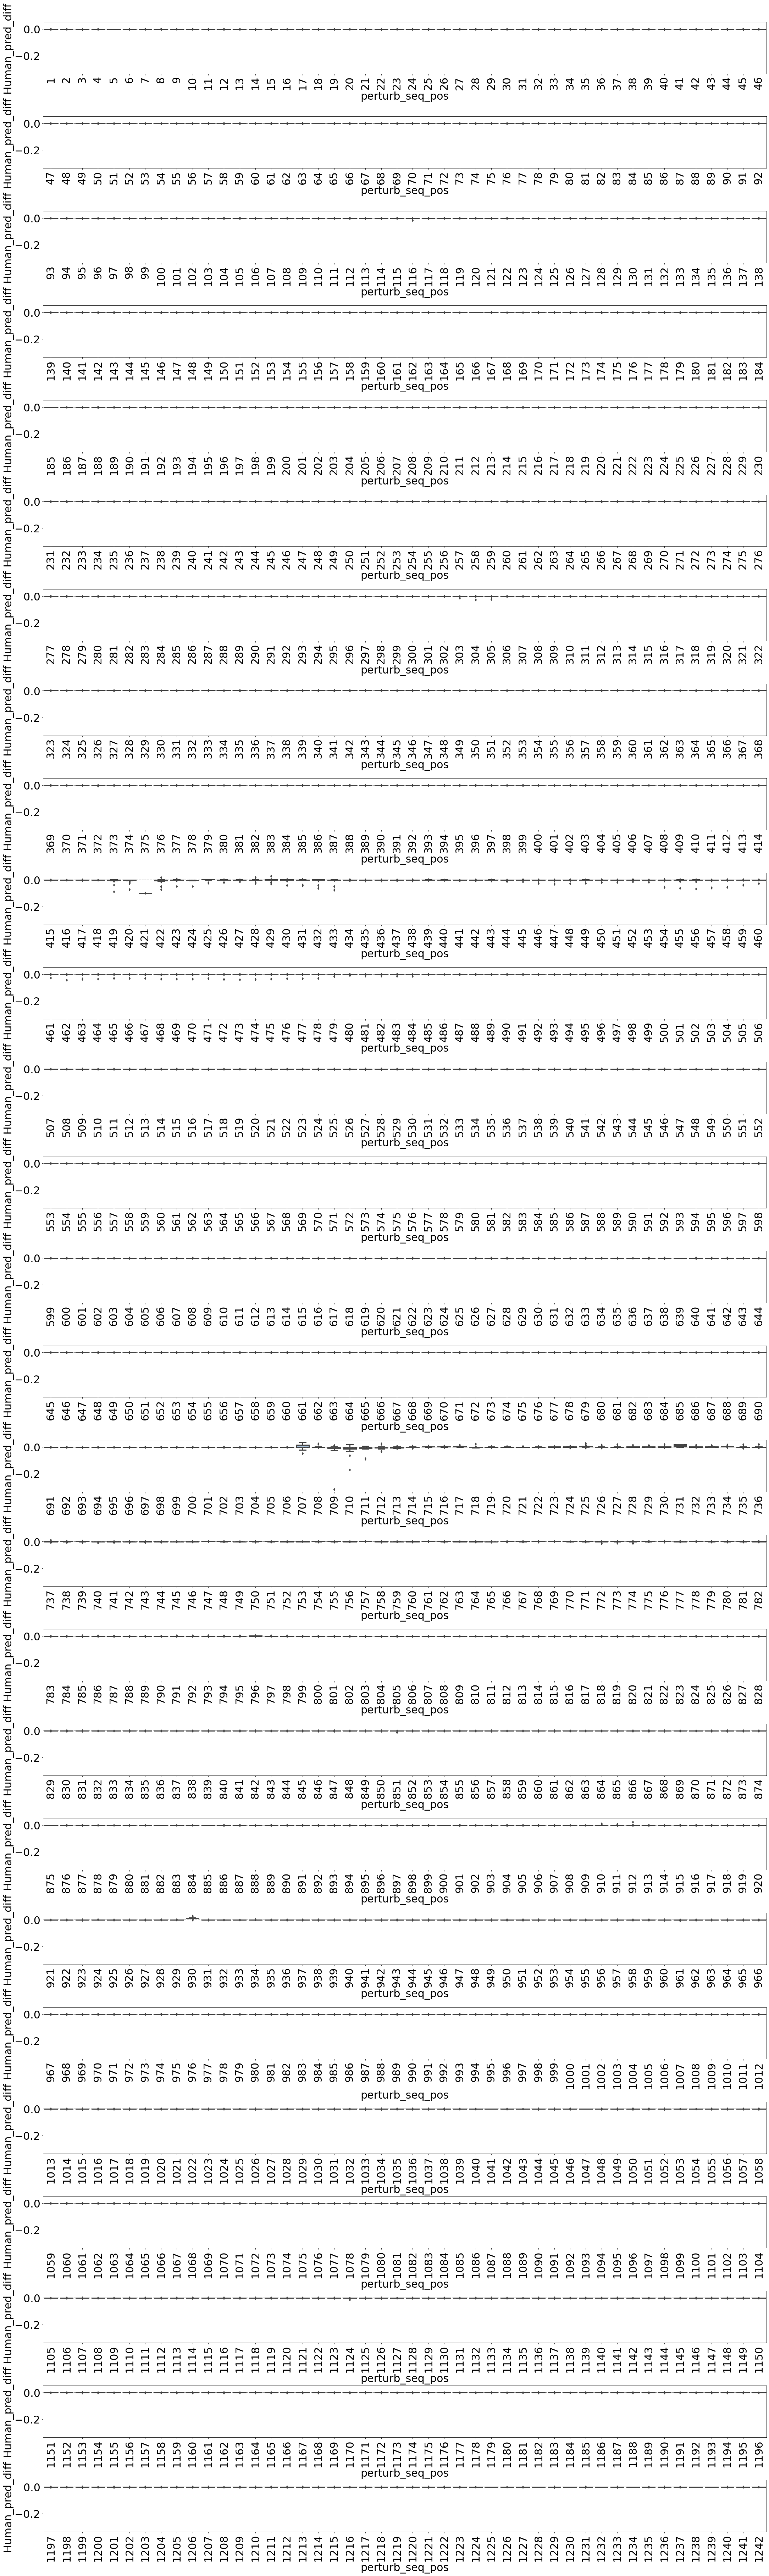

In [22]:
plt.clf()
n = 27
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(n, 1, figsize=(30, 100), sharex=False, sharey=True)

bins = get_uniformly_divided_position_bins(list(cut_off_pos_1), n)

for i in range(n):
    sns.boxplot(data=cut_off_df_1[cut_off_df_1["perturb_seq_pos"].isin(bins[i])],  y="Human_pred_diff", x="perturb_seq_pos", ax=axs[i], orient="v", 
                linewidth=3,
                boxprops={"facecolor": (.3, .5, .7, .5)})
    axs[i].tick_params(axis='x', rotation=90)
    axs[i].axhline(0.0, color="gray", linestyle="--")
    
plt.tight_layout(pad=.1)
plt.show()

### Cut-off: abs_Human_pred_diff >= 0.1

In [23]:
cut_off_df_2 = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
cut_off_pos_2 = set(cut_off_df_2["perturb_seq_pos"].unique())
print(f"1. Number of unique positions with mean !=0 and variance != 0 : {len(cut_off_pos_1)}")
print(f"2. Number of unique positions with abs_{pred_diff_col} > 0.1 : {len(cut_off_pos_2)}")

print(f"1 intersection 2: {len(cut_off_pos_1.intersection(cut_off_pos_2))}")
print(f"1 minus 2: {len(cut_off_pos_1 - cut_off_pos_2)}")
print(f"2 minus 1: {len(cut_off_pos_2 - cut_off_pos_1)}")
print(f"is 2 subset of 1: {cut_off_pos_2 <= cut_off_pos_1}")

1. Number of unique positions with mean !=0 and variance != 0 : 1264
2. Number of unique positions with abs_Human_pred_diff > 0.1 : 3
1 intersection 2: 3
1 minus 2: 1261
2 minus 1: 0
is 2 subset of 1: True


<Figure size 432x288 with 0 Axes>

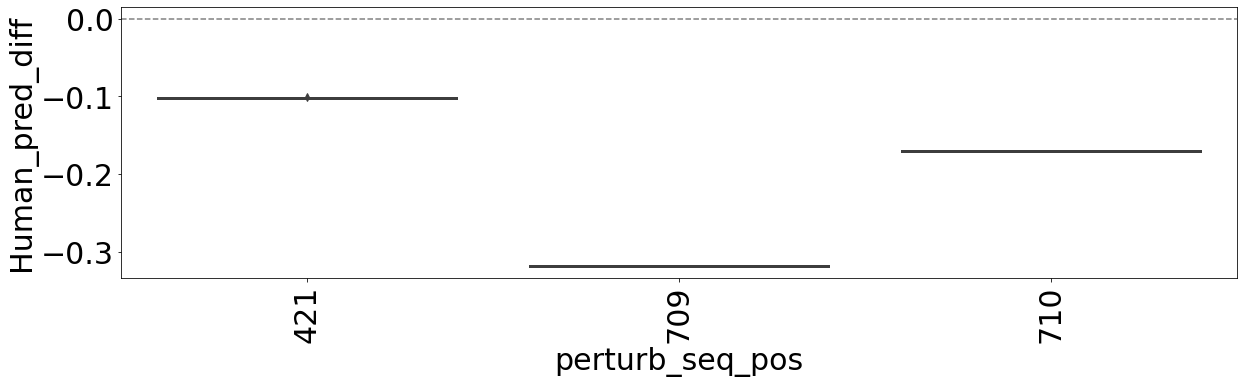

In [24]:
plt.clf()
n = 1
fig, axs = plt.subplots(n, 1, figsize=(20, 5), sharey=True)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams.update({'font.size': 20})

bins = get_uniformly_divided_position_bins(list(cut_off_pos_2), n)

for i in range(1):
    sns.boxplot(data=cut_off_df_2[cut_off_df_2["perturb_seq_pos"].isin(bins[i])],  y="Human_pred_diff", x="perturb_seq_pos", ax=axs, orient="v", 
                linewidth=3,
                boxprops={"facecolor": (.3, .5, .7, .5)})
    axs.tick_params(axis='x', rotation=90)
    axs.axhline(0.0, color="gray", linestyle="--")

plt.show()


## Identified important mutations
**Cut-off: abs_Human_pred_diff >= 0.1**

### Mutations with new token=X

In [25]:
cut_off_df_2["perturbation_id"] = cut_off_df_2["orig_token"] + cut_off_df_2["perturb_seq_pos"].astype("str") + cut_off_df_2["new_token"]
x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] == "X"]
non_x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] != "X"].copy()

/tmp/ipykernel_1418958/3113693862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_off_df_2["perturbation_id"] = cut_off_df_2["orig_token"] + cut_off_df_2["perturb_seq_pos"].astype("str") + cut_off_df_2["new_token"]


<Figure size 432x288 with 0 Axes>

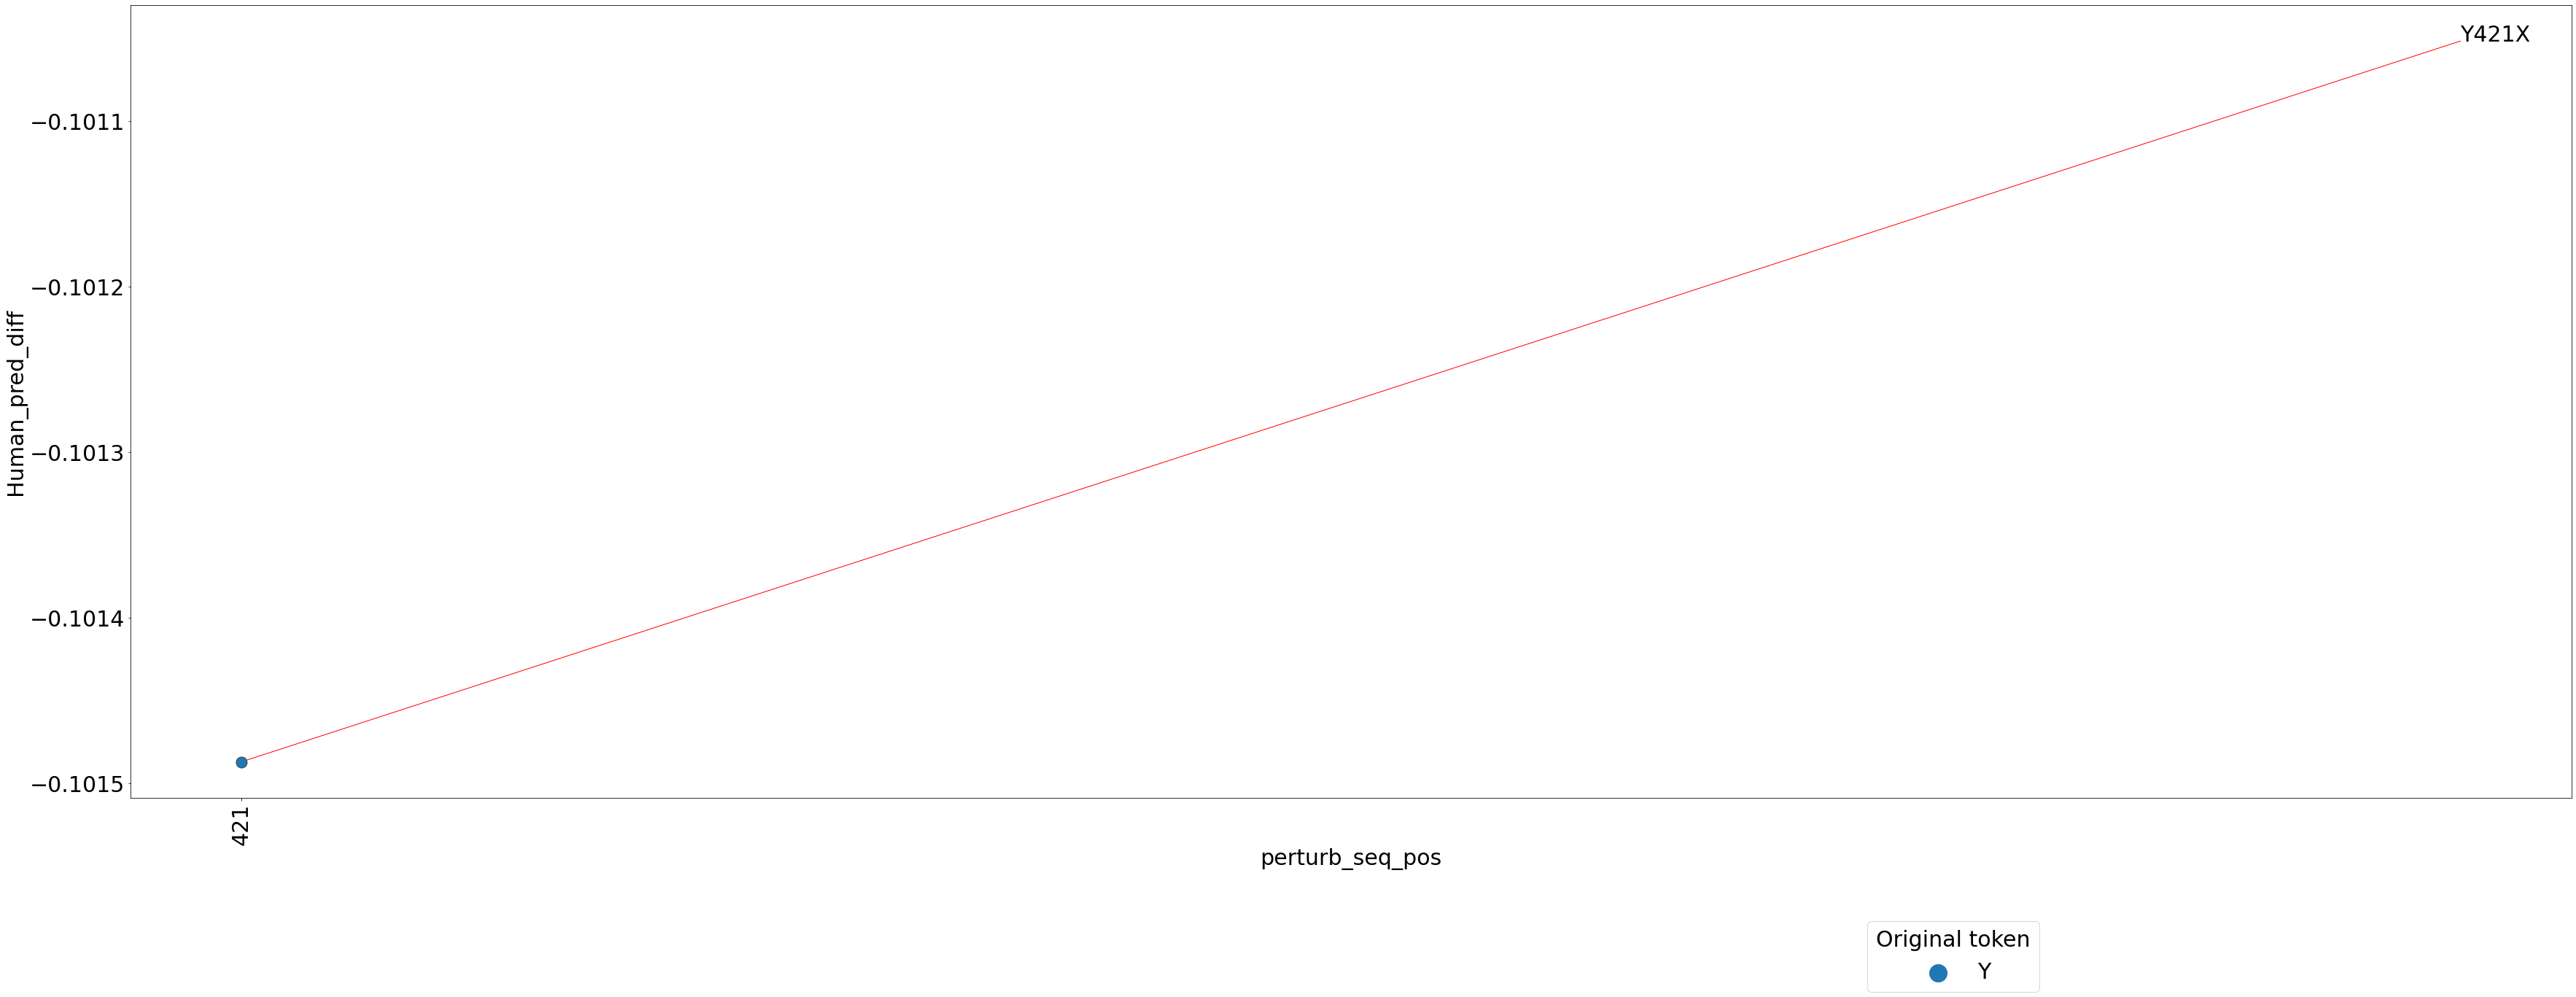

In [26]:
import textalloc as ta
plt.clf()
plt.figure(figsize=(60, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
annotate_df = x_mutation_df.sort_values(f"abs_{pred_diff_col}", ascending=False)[:20]
ax = sns.stripplot(data=x_mutation_df, y="Human_pred_diff", x="perturb_seq_pos", hue="orig_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
x_mapping = {}
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="Original token")
ax.tick_params(axis='x', rotation=90)
for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]
text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_seq_pos"])])
    y.append(row["Human_pred_diff"])
ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in x_mutation_df["perturb_seq_pos"].values], 
            y_scatter=x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [27]:
annotate_df

,Cat,Cattle,Chicken,Dromedary camel,Gray wolf,Human,Pig,Yak,uniprot_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturb_seq_pos,perturbation_id
8489,0.227738,0.002758,0.021088,0.00315,0.005742,0.72043,0.018921,0.000173,WIV04,Human,Y,899,X,-0.101487,0.101487,Human,Human,421,Y421X


### Mutations with new token NOT = X

In [28]:
print(f"New token != X = {non_x_mutation_df.shape}")
print(f"Number of unique mutations = {non_x_mutation_df['perturbation_id'].nunique()}")
annotate_df_pos = non_x_mutation_df.sort_values(by="Human_pred_diff", axis=0, ascending=False)[:10]
annotate_df_neg = non_x_mutation_df.sort_values("Human_pred_diff", axis=0)[:10]
annotate_df = pd.concat([annotate_df_pos, annotate_df_neg])

New token != X = (26, 19)
Number of unique mutations = 26


<Figure size 432x288 with 0 Axes>

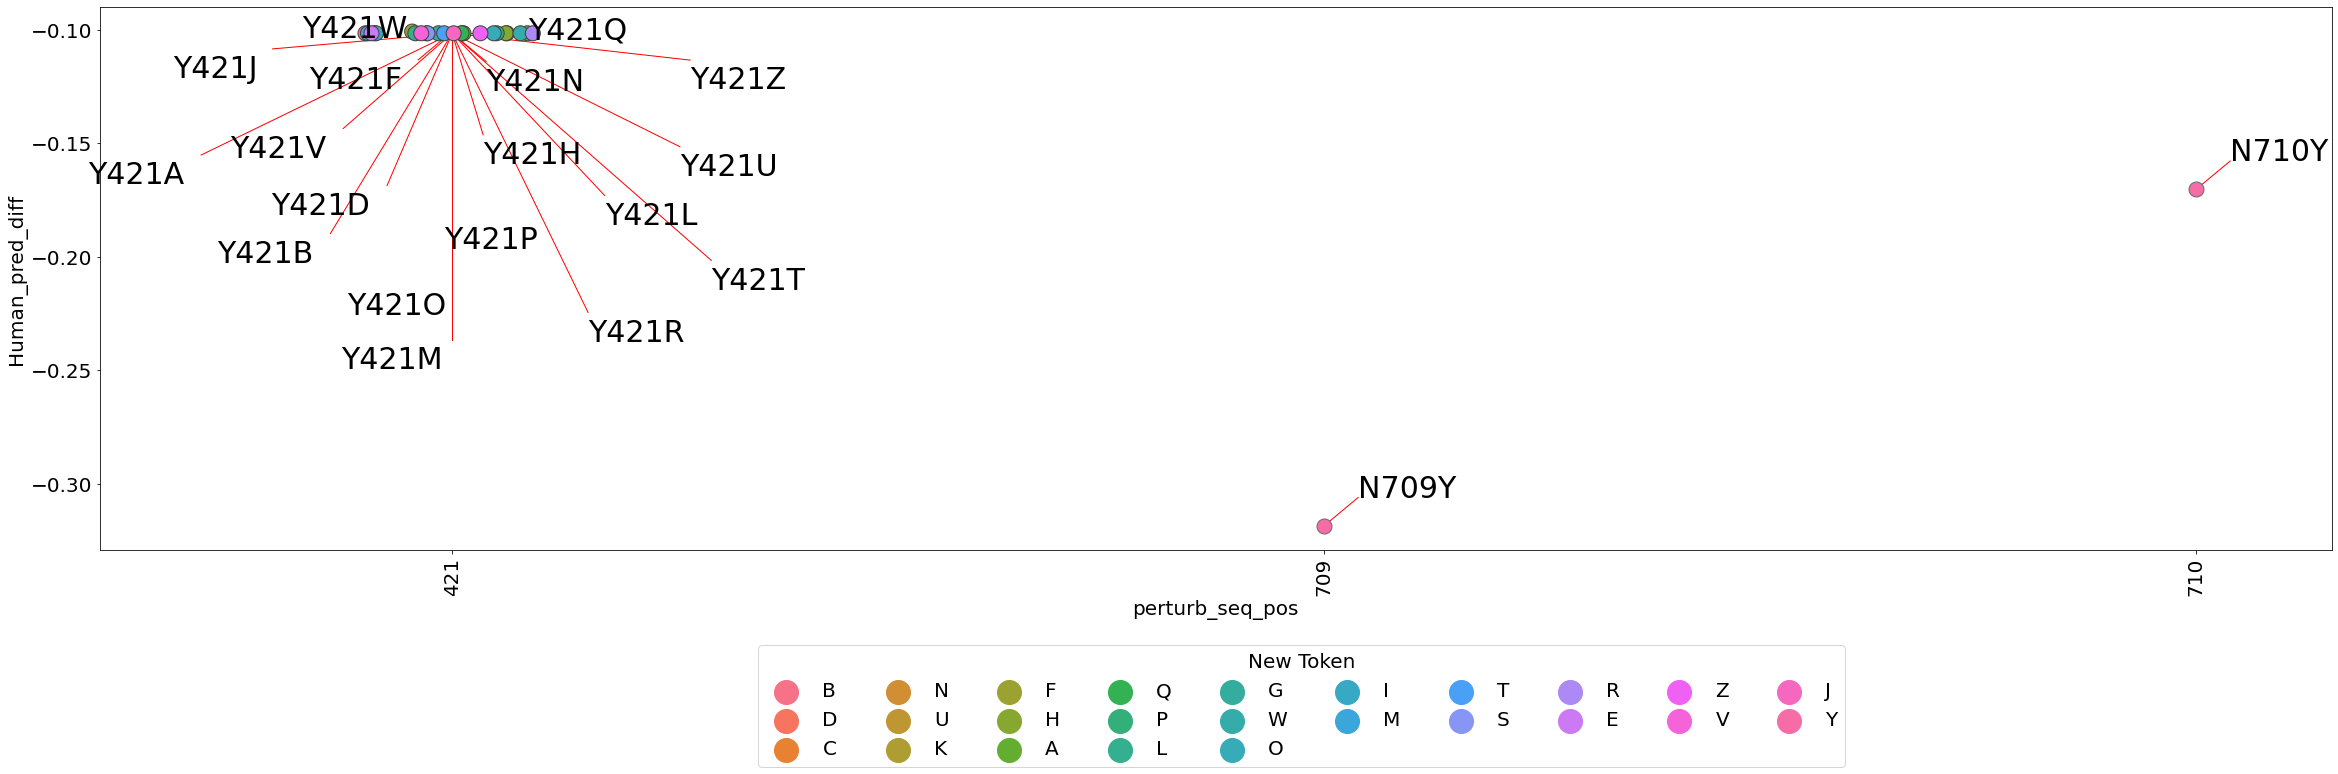

In [29]:
plt.clf()
plt.figure(figsize=(40, 10))
plt.rcParams.update({'font.size': 20})
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

ax = sns.stripplot(data=non_x_mutation_df, x="perturb_seq_pos", y="Human_pred_diff", hue="new_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="New Token")
ax.tick_params(axis='x', rotation=90)

x_mapping = {}

for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]

text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_seq_pos"])])
    y.append(row["Human_pred_diff"])

ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in non_x_mutation_df["perturb_seq_pos"].values], 
            y_scatter=non_x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [30]:
cut_off_df_2["perturbation_id"].nunique()

27

<Figure size 432x288 with 0 Axes>

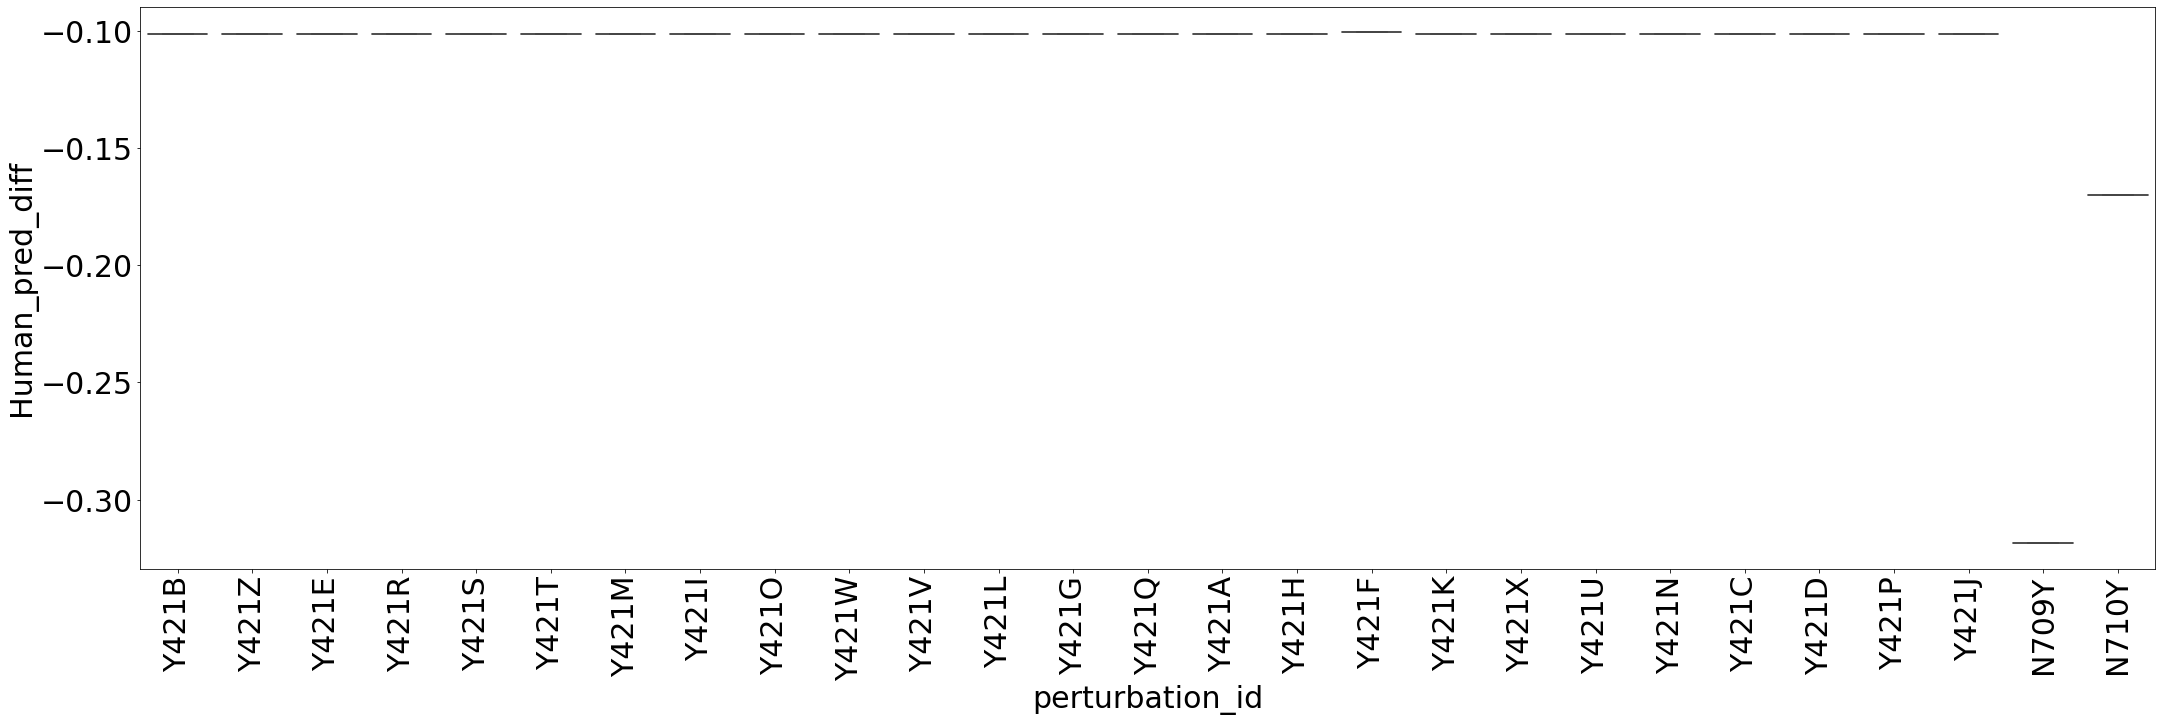

In [31]:
plt.clf()
n = 1
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})

perturbation_ids = cut_off_df_2.sort_values("perturb_seq_pos")["perturbation_id"].unique()
fig, axs = plt.subplots(n, 1, figsize=(30, 10), sharex=False, sharey=True)

bins = get_uniformly_divided_position_bins(list(perturbation_ids), n)

for i in range(n):
    plot_df = cut_off_df_2[cut_off_df_2["perturbation_id"].isin(bins[i])]
    sns.boxplot(plot_df, x="perturbation_id", y=pred_diff_col, ax=axs, orient="v", order=bins[i],
               boxprops={"facecolor": (.3, .5, .7, .5)})
    axs.tick_params(axis='x', rotation=90)
    
plt.tight_layout(pad=.2)
plt.show()

## Known Mutations

In [57]:
s_mutations_file_path = os.path.join(os.getcwd(), "..", "..", "..","..", "..", "input/data/coronaviridae/20240313/wiv04/SARS_CoV_2_WIV04_mutations_grouped_filtered.csv")
s_mutations_df = pd.read_csv(s_mutations_file_path)
#s_mutations_df["perturbation_id"] = s_mutations_df["orig_token"] + s_mutations_df["pos"].astype("str") + s_mutations_df["new_token"]
s_mutations_df

,spike_mutations,pango_lineage,variant_count
0,A222V,['B.1.177'],1
1,A264D,"['JN.1', 'JN.4']",2
2,A27S,"['BA.2', 'BA.2.12.1', 'BA.2.75', 'JN.1', 'BA.4...",27
3,A475V,"['XBB.1.5', 'JD.1.1', 'JD.1.1.1', 'GW.5.1.1', ...",5
4,A570D,['B.1.1.7'],1
...,...,...,...
129,V83A,"['EG.5.1', 'XBB.1.5', 'JD.1.1', 'JD.1.1.1', 'J...",16
130,W152C,"['B.1.427, B.1.429']",1
131,W152R,['BA.2.75'],1
132,Y248H,"['XBB.1.5', 'JD.1.1.1']",2


In [58]:
perturbed_output_df["perturbation_id"] = perturbed_output_df.apply(lambda x: f"{x['orig_token']}{x['perturb_seq_pos']}{x['new_token']}", axis=1)

In [59]:
known_mutations_df = perturbed_output_df[perturbed_output_df["perturbation_id"].isin(s_mutations_df["spike_mutations"])]

# s_mutations_df = s_mutations_df.merge(known_mutations_df[["perturbation_id", "label"]], on="perturbation_id")
# s_mutations_df

<Figure size 432x288 with 0 Axes>

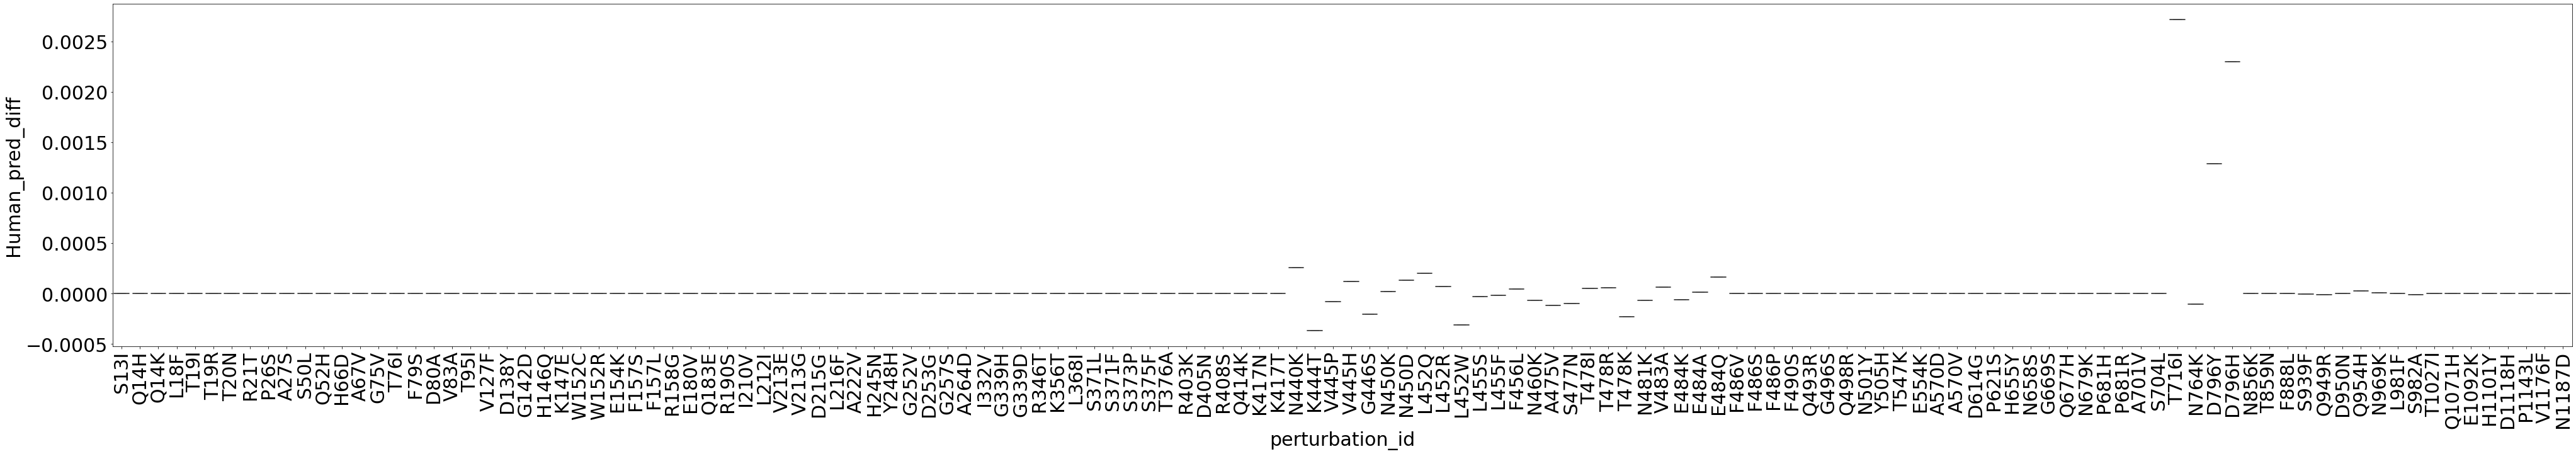

In [69]:
plt.clf()
plt.figure(figsize=(70, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.boxplot(data=known_mutations_df, x="perturbation_id", y="Human_pred_diff", 
                 order=known_mutations_df.sort_values("perturb_seq_pos")["perturbation_id"].unique(),
                 boxprops={"facecolor": (.3, .5, .7, .5)})

ax.tick_params(axis='x', rotation=90)
plt.show()

### Identified and Known Mutations

In [71]:
identified_mutations = set(cut_off_df_2["perturbation_id"].unique())
known_mutations = set(s_mutations_df["spike_mutations"].unique())
print(f"identified_mutations = {len(identified_mutations)}")
print(f"known_mutations = {len(known_mutations)}")
print(f"intersection = {identified_mutations.intersection(known_mutations)}")
intersection = list(identified_mutations.intersection(known_mutations))

identified_mutations = 27
known_mutations = 134
intersection = set()


In [ ]:
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 2, figsize=(40, 10), sharex=True, sharey=True)

j=0
plot_dfs = []
for i in intersection:
    row = s_mutations_df[s_mutations_df["perturbation_id"] == i]
    plot_df = get_distribution_df(perturbed_output_df, 
                                    orig_token=row["orig_token"].values[0],
                                    perturb_pos=row["pos"].values[0],
                                    perturbation_id=i,
                                    perturbation_id_label=row["label"].values[0])
    sns.kdeplot(data=plot_df, x="Human_pred_diff", hue="type", ax=axs[j], legend=True)
    axs[j].set_title(row["label"].values[0])
    plot_dfs.append(plot_df)
    j += 1
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="30")
plt.tight_layout()
plt.show()


In [ ]:
plt.clf()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.violinplot(pd.concat(plot_dfs), x="label", y="Human_pred_diff", hue="type")
#ax = (data=pd.concat(plot_dfs), x="perturbation_id", y="Human_pred_diff", hue="type", notch=True)
#ax.tick_params(axis='x', rotation=90)
ax.legend(bbox_to_anchor=(.8, -0.1), fontsize="30")
plt.tight_layout(pad=.2)
plt.show()

In [ ]:
plt.clf()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.boxplot(pd.concat(plot_dfs), x="label", y="Human_pred_diff", hue="type", notch=True)
#ax = (data=pd.concat(plot_dfs), x="perturbation_id", y="Human_pred_diff", hue="type", notch=True)
#ax.tick_params(axis='x', rotation=90)
ax.legend(bbox_to_anchor=(.8, -0.1), fontsize="30")
plt.tight_layout(pad=.2)
plt.show()